# Percentile Method

In [87]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

First, we read data from the log_normal file and store our 15 samples

In [88]:
def read_numbers_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        numbers = content.split()
        numbers = [float(num) for num in numbers]
    return numbers


file_path = 'logNormal.txt'
data = read_numbers_from_file(file_path)

Now, we create a funcn for bootstrapping from the sample and create the distribution of its mean

In [89]:
def bootstrap_means(data, n_bootstrap=1000):
    bootstrap_samples = np.random.choice(data, (n_bootstrap, len(data)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    return bootstrap_means

Now we use percentile method, by cutting off X samples corresponding to aplha from right and from left

In [90]:
def percentile_confidence_interval(data, alpha=0.05):
    lower_percentile = 100 * (alpha / 2)
    upper_percentile = 100 * (1 - alpha / 2)
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return lower_bound, upper_bound

In [91]:
n_bootstrap = 1000
alpha = 0.05

bootstrap_means_sample = bootstrap_means(data, n_bootstrap)
lower_bound, upper_bound = percentile_confidence_interval(bootstrap_means_sample, alpha)
print(f"95% confidence interval from percentile: ({lower_bound}, {upper_bound})")

95% confidence interval from percentile: (1.3830916724500002, 3.9479194866833343)


### Plot the confidence interval

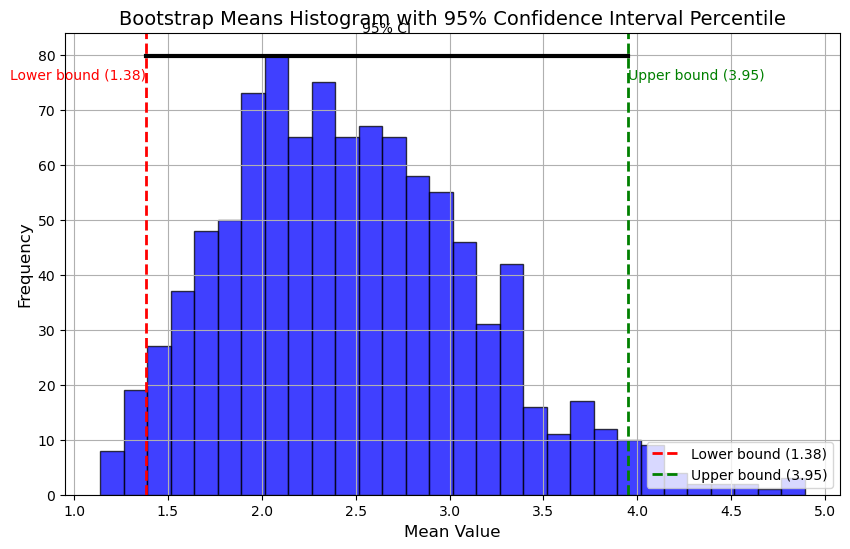

In [92]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means_sample, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=2, label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(x=upper_bound, color='green', linestyle='--', linewidth=2, label=f'Upper bound ({upper_bound:.2f})')

# Add text annotations
plt.text(lower_bound, plt.ylim()[1]*0.9, f'Lower bound ({lower_bound:.2f})', color='red', horizontalalignment='right')
plt.text(upper_bound, plt.ylim()[1]*0.9, f'Upper bound ({upper_bound:.2f})', color='green', horizontalalignment='left')

# Additional line for 95% CI
plt.plot([lower_bound, upper_bound], [plt.ylim()[1]*0.95, plt.ylim()[1]*0.95], color='black', linewidth=3)
plt.text((lower_bound + upper_bound) / 2, plt.ylim()[1], '95% CI', color='black', horizontalalignment='center')

# Set titles and labels
plt.title('Bootstrap Means Histogram with 95% Confidence Interval Percentile', fontsize=14)
plt.xlabel('Mean Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

# BCa (Bias-Corrected and accelerated)

In [93]:
def bca_confidence_interval(data, bootstrap_means_sample, alpha=0.05):
    theta_hat = np.mean(data)
    z0 = norm.ppf((np.sum(bootstrap_means_sample < theta_hat)) / len(bootstrap_means_sample))
    jackknife_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
    jackknife_mean = np.mean(jackknife_means)
    a = np.sum((jackknife_mean - jackknife_means) ** 3) / (6 * np.sum((jackknife_mean - jackknife_means) ** 2) ** 1.5)
    lower_percentile = 100 * norm.cdf(z0 + (z0 + norm.ppf(alpha / 2)) / (1 - a * (z0 + norm.ppf(alpha / 2))))
    upper_percentile = 100 * norm.cdf(z0 + (z0 + norm.ppf(1 - alpha / 2)) / (1 - a * (z0 + norm.ppf(1 - alpha / 2))))
    lower_bound = np.percentile(bootstrap_means_sample, lower_percentile)
    upper_bound = np.percentile(bootstrap_means_sample, upper_percentile)
    return lower_bound, upper_bound

Calculate the lower and upper intervals

In [94]:
lower_bound, upper_bound = bca_confidence_interval(data, bootstrap_means_sample, alpha)
print(f"95% BCa confidence interval: ({lower_bound}, {upper_bound})")

95% BCa confidence interval: (1.4976858024295463, 4.359388278108974)


### Plot the Interval

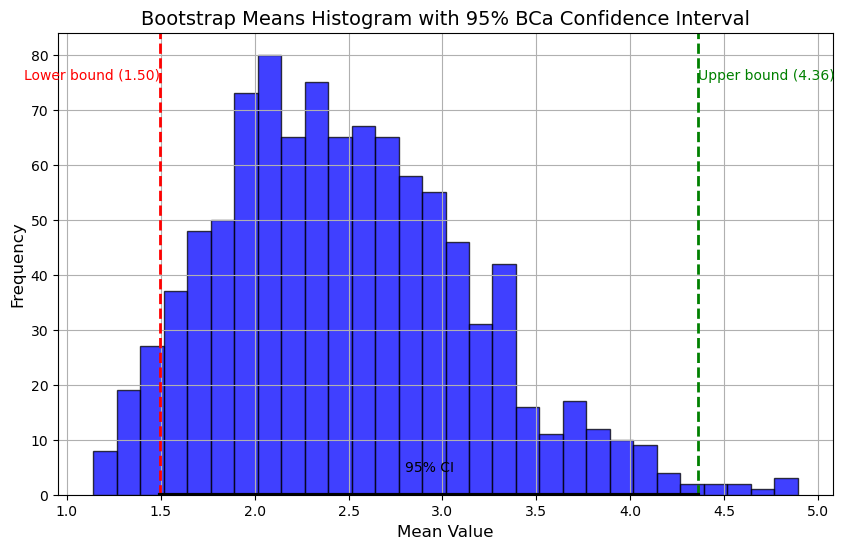

In [95]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means_sample, bins=30, alpha=0.75, color='blue', edgecolor='black')

# Add vertical lines for the confidence interval
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=2)
plt.axvline(x=upper_bound, color='green', linestyle='--', linewidth=2)

# Add text annotations for the bounds
plt.text(lower_bound, plt.ylim()[1]*0.9, f'Lower bound ({lower_bound:.2f})', color='red', ha='right')
plt.text(upper_bound, plt.ylim()[1]*0.9, f'Upper bound ({upper_bound:.2f})', color='green', ha='left')

# Add a line and text for the 95% CI
plt.plot([lower_bound, upper_bound], [0, 0], color='black', linewidth=3)
plt.text((lower_bound + upper_bound) / 2, plt.ylim()[1]*0.05, '95% CI', color='black', ha='center')

# Set titles and labels
plt.title('Bootstrap Means Histogram with 95% BCa Confidence Interval', fontsize=14)
plt.xlabel('Mean Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

## Comparison between miss percentage of both the Methods

In [96]:
population = data
n_simulations = 10000
n_bootstrap = 1000
sample_size = 15
alpha = 0.05
true_mean = np.mean(population)
percentile_miss_left = 0
percentile_miss_right = 0
bca_miss_left = 0
bca_miss_right = 0

In [97]:
for _ in range(n_simulations):
    sample = np.random.choice(population, sample_size, replace=True)
    bootstrap_means_sample = bootstrap_means(sample, n_bootstrap)

    perc_lower, perc_upper = percentile_confidence_interval(bootstrap_means_sample, alpha)
    bca_lower, bca_upper = bca_confidence_interval(sample, bootstrap_means_sample, alpha)

    if perc_lower > true_mean:
        percentile_miss_left += 1
    elif perc_upper < true_mean:
        percentile_miss_right += 1

    if bca_lower > true_mean:
        bca_miss_left += 1
    elif bca_upper < true_mean:
        bca_miss_right += 1

percentile_miss_left /= n_simulations
percentile_miss_right /= n_simulations
bca_miss_left /= n_simulations
bca_miss_right /= n_simulations

In [98]:
bt_means = bootstrap_means(data, n_bootstrap)

alpha = 0.05
percentile_lower_bound, percentile_upper_bound = percentile_confidence_interval(bt_means, alpha)
bca_lower_bound, bca_upper_bound = bca_confidence_interval(data, bt_means, alpha)

# Print the confidence intervals
print(f"95% Percentile confidence interval: ({percentile_lower_bound}, {percentile_upper_bound})")
print(f"95% BCa confidence interval: ({bca_lower_bound}, {bca_upper_bound})")

95% Percentile confidence interval: (1.3578318177666666, 3.8491892911999996)
95% BCa confidence interval: (1.4917918726507882, 4.386480699702342)


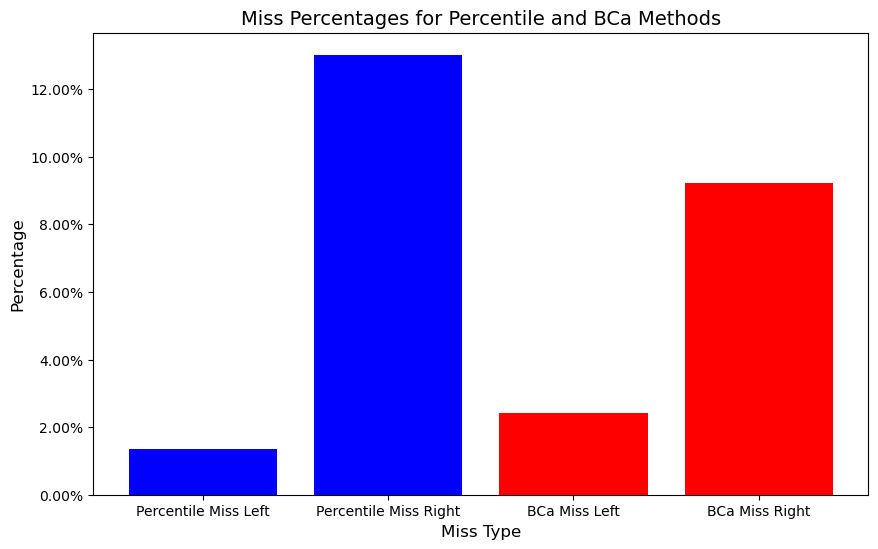

Percentile Method Miss Left: 1.35%
Percentile Method Miss Right: 13.02%
BCa Method Miss Left: 2.42%
BCa Method Miss Right: 9.22%


In [99]:
# Visualization
categories = ['Percentile Miss Left', 'Percentile Miss Right', 'BCa Miss Left', 'BCa Miss Right']
values = [percentile_miss_left, percentile_miss_right, bca_miss_left, bca_miss_right]
colors = ['blue', 'blue', 'red', 'red']

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors)

# Add title and axis labels
plt.title('Miss Percentages for Percentile and BCa Methods', fontsize=14)
plt.xlabel('Miss Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# Show the plot
plt.show()

# Print the miss percentages
print(f"Percentile Method Miss Left: {percentile_miss_left:.2%}")
print(f"Percentile Method Miss Right: {percentile_miss_right:.2%}")
print(f"BCa Method Miss Left: {bca_miss_left:.2%}")
print(f"BCa Method Miss Right: {bca_miss_right:.2%}")

# Conclusion

### For 95% the ideal left and right miss should be 2.5% 
### We can observe that BCa has a better miss left and miss right percentage compared to Percentile. 
### Hence BCa gives a better interval compared to Percentile method.